In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from trainer.supervised_trainer_unmatching import SupervisedTrainer_unmatching
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.evaluator import Evaluator
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
train_path = "data/bracket_dedup/K100/data_train.txt"
log_path_att = "log/pth/bracket_dedup_K100_parameter_Luong_att_model_save.pth"
log_path_no = "log/pth/bracket_dedup_K100_parameter_no_att_model_save.pth"

In [3]:
LOG_FORMAT = '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, "info".upper()))

In [4]:
# Prepare dataset
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 102
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)

In [5]:
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

In [6]:
# Prepare loss
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

optimizer = "Adam"
hidden_size = 50
bidirectional = True

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Initialize model Luong Att

In [7]:
# Initialize model
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=1,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional, n_layers=1,
                    eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

seq2seq.load_state_dict(torch.load(log_path_att))
seq2seq.eval()

evaluator = Evaluator(loss=loss, batch_size=32)

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [8]:
character_accuracy_list_att = []
sentance_accuracy_list_att = []

In [9]:
lengths = list(range(2, 101, 4))
print(lengths)
for i in lengths:
    dev_path = "data/bracket_dedup/K100/dev/data_test_line_" + str(i) + ".txt"
    dev = torchtext.data.TabularDataset(
        path=dev_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    _, character_accuracy, sentance_accuracy = evaluator.evaluate(seq2seq, dev)
    character_accuracy_list_att.append(character_accuracy)
    sentance_accuracy_list_att.append(sentance_accuracy)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74, 78, 82, 86, 90, 94, 98]


/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


# Initialize model None Att

In [10]:
# Initialize model
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=1,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention=None, bidirectional=bidirectional, n_layers=1,
                    eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

seq2seq.load_state_dict(torch.load(log_path_no))
seq2seq.eval()

evaluator = Evaluator(loss=loss, batch_size=32)

In [11]:
character_accuracy_list_no = []
sentance_accuracy_list_no = []

In [12]:
lengths = list(range(2, 101, 4))
print(lengths)
for i in lengths:
    dev_path = "data/bracket_dedup/K100/dev/data_test_line_" + str(i) + ".txt"
    dev = torchtext.data.TabularDataset(
        path=dev_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    _, character_accuracy, sentance_accuracy = evaluator.evaluate(seq2seq, dev)
    character_accuracy_list_no.append(character_accuracy)
    sentance_accuracy_list_no.append(sentance_accuracy)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74, 78, 82, 86, 90, 94, 98]


# Evaluation Result

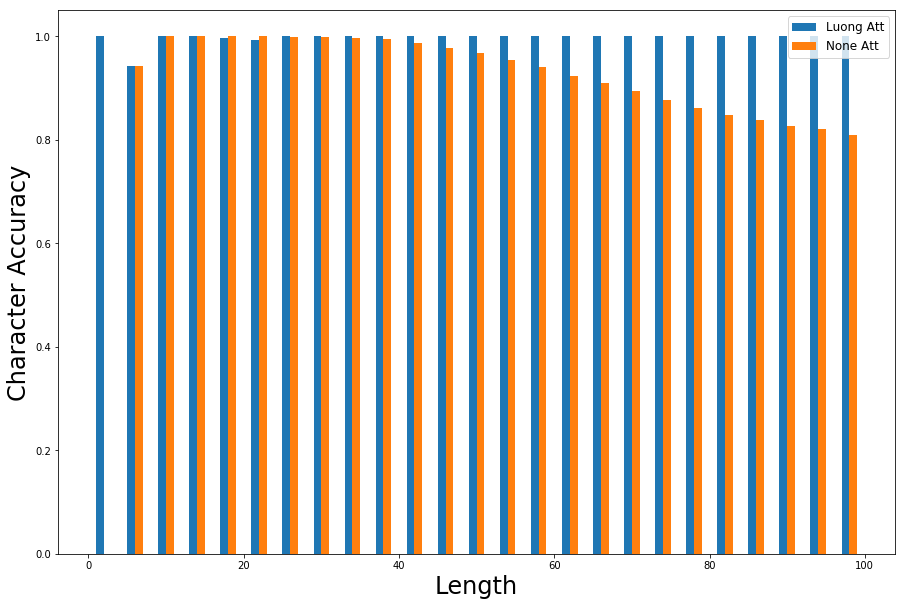

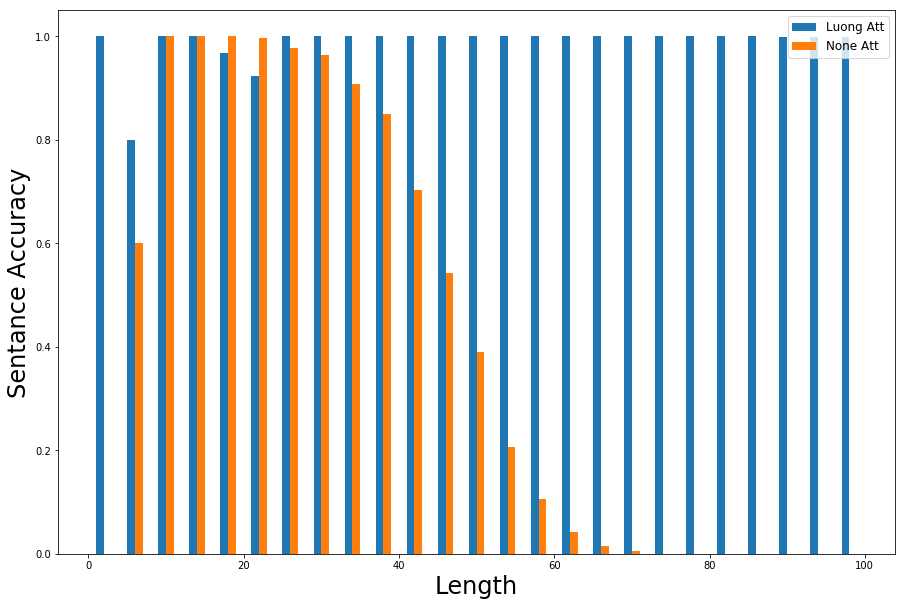

In [14]:
plt.figure(figsize=(15,10))
plt.bar([i-0.5 for i in lengths], character_accuracy_list_att, width=1, label="Luong Att")
plt.bar([i+0.5 for i in lengths], character_accuracy_list_no, width=1, label="None Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Length', fontsize=24)
plt.ylabel('Character Accuracy', fontsize=24)
#plt.ylim([0, 1])
plt.savefig('log/plot/eval_bracket_length_to_accuracy/length_to_character_accuracy.png')

plt.figure(figsize=(15,10))
plt.bar([i-0.5 for i in lengths], sentance_accuracy_list_att, width=1, label="Luong Att")
plt.bar([i+0.5 for i in lengths], sentance_accuracy_list_no, width=1, label="None Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Length', fontsize=24)
plt.ylabel('Sentance Accuracy', fontsize=24)
#plt.ylim([0, 1])
plt.savefig('log/plot/eval_bracket_length_to_accuracy/length_to_sentance_accuracy.png')